In [1]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
from nocap.utils import get_device
from nocap.dataset import Flickr30k
import matplotlib.pyplot as plt
from collections import Counter

/home/kenton/miniconda3/envs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Flickr30k

In [2]:
hf_ds = load_dataset("nlphuji/flickr30k")
print(hf_ds)
print(Counter(hf_ds['test']['split']))

DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
        num_rows: 31014
    })
})
Counter({'train': 29000, 'val': 1014, 'test': 1000})


Dataset

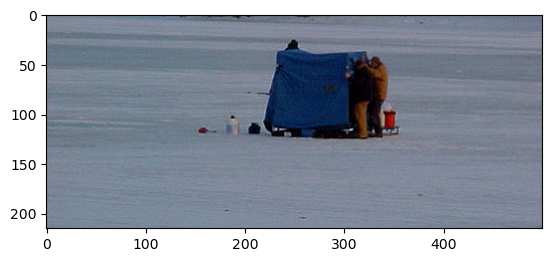

(tensor([[[112, 113, 113,  ...,  65,  73,  89],
          [108, 109, 113,  ..., 116, 113, 112],
          [118, 118, 119,  ..., 111, 111, 110],
          ...,
          [119, 119, 120,  ..., 118, 118, 118],
          [130, 128, 126,  ..., 110, 111, 111],
          [125, 123, 122,  ..., 118, 119, 120]],
 
         [[125, 126, 126,  ...,  71,  81,  97],
          [129, 130, 131,  ..., 121, 119, 118],
          [131, 129, 130,  ..., 116, 118, 117],
          ...,
          [130, 130, 131,  ..., 125, 125, 125],
          [139, 137, 135,  ..., 117, 118, 118],
          [132, 130, 127,  ..., 125, 126, 125]],
 
         [[141, 142, 142,  ...,  83,  92, 108],
          [148, 149, 151,  ..., 143, 141, 140],
          [148, 149, 150,  ..., 135, 136, 135],
          ...,
          [148, 148, 149,  ..., 144, 144, 144],
          [156, 154, 152,  ..., 136, 137, 137],
          [148, 146, 146,  ..., 144, 145, 145]]], dtype=torch.uint8),
 'Two men, standing on an ice, looking into something covered w

In [3]:
ds = Flickr30k('val')

plt.imshow(ds[3][0].permute(1,2,0))
plt.show()
ds[3]

Now the pre-trained models

In [14]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

inputs = processor(images=image, return_tensors="pt")
print(inputs['pixel_values'].shape)
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


torch.Size([1, 3, 224, 224])
Predicted class: Egyptian cat


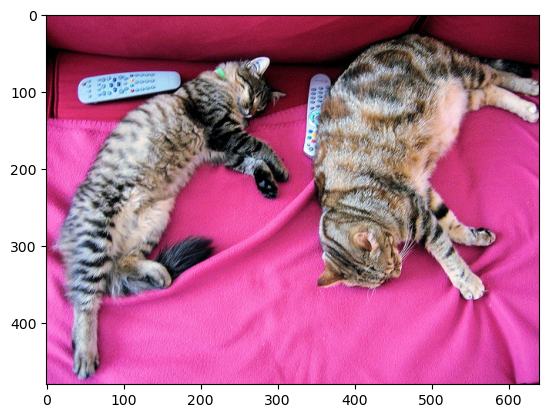

In [7]:
plt.imshow(image)

In [ ]:
from transformers import pipeline, CLIPModel, CLIPConfig
import torch

clip = pipeline(
   task="zero-shot-image-classification",
   model="openai/clip-vit-base-patch32",
   torch_dtype=torch.bfloat16,
   device=0
)
labels = ["a photo of a cat", "a photo of a dog", "a photo of a car"]
clip("http://images.cocodataset.org/val2017/000000039769.jpg", candidate_labels=labels)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


[{'score': 0.9921875, 'label': 'a photo of a cat'},
 {'score': 0.005218505859375, 'label': 'a photo of a car'},
 {'score': 0.0031585693359375, 'label': 'a photo of a dog'}]

In [9]:
configuration = CLIPConfig()
CLIPModel(configuration)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
from torch import nn
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPVisionModel, CLIPTextModel, AutoTokenizer
from nocap.models import ImageCaptioner, process_padding
from copy import deepcopy

model_dict = {
    'vision_model' : CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32"),
    'text_model': CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32"),
    'image_processor': AutoProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=True),
    'text_tokeniser': AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32",),
    'vision_hidden_dim': 768,
    'text_hidden_dim': 512
}

captioning_model = ImageCaptioner(model_dict) 

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
# Remember to shift by one (remove the end token)
processed_images, processed_text = captioning_model.process_batch([image, image], ["a photo of a cat", "cat cat"])

# Make inputs, 
text_inputs = deepcopy(processed_text) 
text_inputs['input_ids'] = text_inputs['input_ids'][:,:-1]
text_inputs['attention_mask'] = text_inputs['attention_mask'][:, :-1]

# Make outputs
text_targets = process_padding(processed_text['input_ids'][:,1:], )
res = captioning_model.forward(processed_images, text_inputs)

res.shape

torch.Size([2, 50, 768]) torch.Size([2, 6, 512])


torch.Size([2, 6, 49408])

In [36]:
text_inputs['input_ids']

tensor([[49406,   320,  1125,   539,   320,  2368],
        [49406,  2368,  2368, 49407, 49407, 49407]])

In [ ]:
import torch



process_padding(processed_text['input_ids'][:,1:])

tensor([[  320,  1125,   539,   320,  2368, 49407],
        [ 2368,  2368, 49407, 49406, 49406, 49406]])

In [35]:
text_targets

tensor([[  320,  1125,   539,   320,  2368, 49407],
        [ 2368,  2368, 49407, 49407, 49407, 49407]])

In [ ]:
from torch.nn import CrossEntropyLoss

loss = CrossEntropyLoss(ignore_index=49406)
loss(res.reshape(-1, 49408), text_targets.flatten())

In [47]:
res.shape

torch.Size([2, 6, 49408])

In [49]:
text_targets.shape

torch.Size([2, 6])

In [51]:
res.shape

torch.Size([2, 6, 49408])

tensor(11.1322, grad_fn=<NllLossBackward0>)

In [85]:
captioning_model.text_model(text_inputs.input_ids).last_hidden_state

tensor([[[ 0.3393,  0.1165,  0.1020,  ...,  0.2468,  0.5906,  0.1013],
         [ 1.9753, -0.5844,  0.3685,  ...,  1.1658,  0.8050, -0.9801],
         [ 1.0580, -0.9600,  1.0018,  ..., -0.5155, -0.1437, -1.9444],
         ...,
         [ 0.3059, -1.5037, -0.4022,  ..., -0.0224,  0.9105, -0.3916],
         [ 1.0118, -0.6701,  1.7742,  ..., -0.1556, -0.0250, -1.5062],
         [-0.5152,  0.1658,  0.8876,  ..., -0.0675, -0.4551, -1.7960]]],
       grad_fn=<NativeLayerNormBackward0>)

In [ ]:
bos, eos = captioning_model.text_tokenizer([""])['input_ids'][0]


49406

In [63]:
len(captioning_model.text_tokenizer)

49408

In [12]:
from nocap.utils import count_trainable_params
count_trainable_params(model_dict['vision_model'])

87456000